# Anime Rating Predictor
#### By Shaun Katanosaka, Nina Nguyen, Hin Yat Tsang

Ever look at the list of upcoming seasonal animes and have no idea if it's going to be good or not? This project aims to solve that problem! Here, we will use machine learning to predict how good an upcoming anime is.

## Getting our Dataset
We will make a dataset which includes looking at every anime on myanimelist.net and gathering information about each one, including categories such as title, score, popularity, the season it initially aired, etc. 
This program might take a very long time to run, due to the rate limitations of accessing the myanimelist API.
The file AnimeList.csv file has every anime up to Nov 8, 2022.

Note: due to MyAnimeList's ddos protection, it is possible that on rare occasion, this process may not work due to the site thinking that our program is a ddos attempt. In this case, you can typically open up myanimelist.net and if they prompt you to make sure you aren't a bot, then do so and run this program again. If not, then you are probably fine to try again.

In [1]:
#we import a package which will be used to access the myanimelist.net's API and gather data
import sys
!{sys.executable} -m pip install --upgrade pip setuptools wheel
!pip install -U mal-api
import csv

from getMalDataset import make_csv
filename = "AnimeList.csv"
#IMPORTANT: this line will take many many hours to complete.
#I suggest commenting it out and instead using the provided AnimeList.csv file provided in AnimeList.zip
minValue = 1
maxValue = 53509
#make_csv(filename, minValue, maxValue, 1, False)

## Exception handling in getMalDataset
#### Example #1
Every anime on MyAnimeList has an ID number associated with it, and the ID number increases by 1 for every added entry into their site. This makes it possible to get every anime on their website by simply iterating through every number. However, due to some enteries not being approved or some being deleted, not all numbers(even small ones) are an ID of an anime. Therefore, we must not attempt to gather data for an anime which does not exist.
```python
def get_anime(idValue):
    try:
        anime=Anime(idValue)
    except:
        ValueError: "idValue is not associated with an anime"
        return False
    else:
        return anime
```
    

#### Example #2
When calling the make_csv function, the user can choose the bounds for the ID values to print to a csv file, how many times to write to the csv file, and how often to give a progress update per update. We give exceptions if these imputed values are not valid.
```python
def make_csv(filename, minIndex, maxIndex, updates, progress_updates = True, progress_increment = .5):
    if maxIndex < minIndex:
        raise ValueError("maxIndex cannot be smaller than minIndex")
    if type(updates) != int:
        raise TypeError("updates must be an int")
    if updates <= 0:
        raise ValueError("updates must be greater or equal to 1")
    if (progress_increment < 0) or (progress_increment > 1):
        raise ValueError("progress_updates must be between 0 and 1")
```

## Our Dataset

In [3]:
import pandas as pd
animes = pd.read_csv(filename)
animes

C:\Users\Cake\AppData\Local\Temp\ipykernel_2140\2243964213.py:2: DtypeWarning: Columns (10,11,12,13,14,15,16,33) have mixed types. Specify dtype option on import or set low_memory=False.
  animes = pd.read_csv(combinedFilename)


,title,title_english,title_japanese,title_synonyms,url,image_url,type,status,genres,themes,...,duration,rating,related_anime,opening_themes,ending_themes,characters,staff,synopsis,background,ID
0,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,[],https://myanimelist.net/anime/1/Cowboy_Bebop,https://cdn.myanimelist.net/images/anime/4/196...,TV,Finished Airing,"['Action', 'Sci-Fi']","['Adult Cast', 'Space']",...,24 min. per ep.,R - 17+ (violence & profanity),"{'Adaptation': ['Cowboy Bebop', 'Shooting Star...","['""Tank!"" by The Seatbelts (eps 1-25)']","['""The Real Folk Blues"" by The Seatbelts feat....",[<mal._anime.AnimeCharacterResult object at 0x...,[<mal._anime.AnimeStaffResult object at 0x0000...,"Crime is timeless. By the year 2071, humanity ...",When Cowboy Bebop first aired in spring of 199...,1
1,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,"[""Cowboy Bebop: Knockin' on Heaven's Door""]",https://myanimelist.net/anime/5/Cowboy_Bebop__...,https://cdn.myanimelist.net/images/anime/1439/...,Movie,Finished Airing,"['Action', 'Sci-Fi']","['Adult Cast', 'Space']",...,1 hr. 55 min.,R - 17+ (violence & profanity),{'Parent story': ['Cowboy Bebop']},"['""Ask DNA"" by The Seatbelts featuring Raju Ra...","['""Gotta Knock a Little Harder"" by The Seatbel...",[<mal._anime.AnimeCharacterResult object at 0x...,[<mal._anime.AnimeStaffResult object at 0x0000...,"Another day, another bounty—such is the life o...",NaN,5
2,Trigun,Trigun,トライガン,[],https://myanimelist.net/anime/6/Trigun,https://cdn.myanimelist.net/images/anime/7/203...,TV,Finished Airing,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",['Adult Cast'],...,24 min. per ep.,PG-13 - Teens 13 or older,"{'Adaptation': ['Trigun'], 'Side story': ['Tri...","['""H.T."" by Tsuneo Imahori']","['""Kaze wa Mirai ni Fuku (The Wind Blows to th...",[<mal._anime.AnimeCharacterResult object at 0x...,[<mal._anime.AnimeStaffResult object at 0x0000...,"Vash the Stampede is the man with a $$60,000,0...",The Japanese release by Victor Entertainment h...,6
3,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),['WHR'],https://myanimelist.net/anime/7/Witch_Hunter_R...,https://cdn.myanimelist.net/images/anime/10/19...,TV,Finished Airing,"['Action', 'Drama', 'Mystery', 'Supernatural']",['Detective'],...,25 min. per ep.,PG-13 - Teens 13 or older,{},"['""Shell"" by Bana']","['""Half Pain"" by Bana (eps 01-14,16-25)', '""Sh...",[<mal._anime.AnimeCharacterResult object at 0x...,[<mal._anime.AnimeStaffResult object at 0x0000...,Witches are individuals with special powers li...,NaN,7
4,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,['Adventure King Beet'],https://myanimelist.net/anime/8/Bouken_Ou_Beet,https://cdn.myanimelist.net/images/anime/7/215...,TV,Finished Airing,"['Adventure', 'Fantasy', 'Supernatural']",[],...,23 min. per ep.,PG - Children,"{'Adaptation': ['Boukenou Beet'], 'Sequel': ['...","['""Emotion"" by Sunbrain', '""Wish Men"" by Sunbr...","['""pureness"" by Nana Kitade (eps 1-13)', '""Dre...",[<mal._anime.AnimeCharacterResult object at 0x...,[<mal._anime.AnimeStaffResult object at 0x0000...,It is the dark century and the people are suff...,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24029,title,title_english,title_japanese,title_synonyms,url,image_url,type,status,genres,themes,...,duration,rating,related_anime,opening_themes,ending_themes,characters,staff,synopsis,background,ID
24030,Busu ni Hanataba wo.,NaN,ブスに花束を。,['A Bouquet for an Ugly Girl'],https://myanimelist.net/anime/53512/Busu_ni_Ha...,https://cdn.myanimelist.net/images/anime/1232/...,NaN,Not yet aired,"['Comedy', 'Romance']",['School'],...,NaN,None,{'Adaptation': ['Busu ni Hanataba wo.']},[],[],[<mal._anime.AnimeCharacterResult object at 0x...,[<mal._anime.AnimeStaffResult object at 0x0000...,Despite what the meaning of her name would sug...,NaN,53512
24031,Oshiri Tantei 7th Season,NaN,おしりたんてい,['Butt Detective'],https://myanimelist.net/anime/53514/Oshiri

## Create our AnimePredictor object
This object will have methods for treating data and predicting scores.

In [4]:
from ScorePredictor import AnimePredictor
animeData = AnimePredictor(animes)

#### Treating our data
We remove enteries where there is poor or missing data, as well as change some categories from string values to float values. This allows us to run a prediction model on our dataset.

In [5]:
animeData.treatData()
print(animeData.X)

       score  scored_by  popularity  members  favorites  episodes  premiered
0       8.75   869456.0          43  1683105      74818      26.0    1998.25
2       8.22   338382.0         245   683856      13886      26.0    1998.25
3       7.25    42079.0        1720   108282        591      26.0    2002.50
4       6.94     6305.0        4957    14589         14      52.0    2004.75
5       7.92    84587.0        1194   172564       1943     145.0    2005.25
...      ...        ...         ...      ...        ...       ...        ...
22652    6.9    55702.0        1256   161714       1023      13.0    2022.50
22878   5.05      241.0        6447     7637         67      13.0    2022.50
22927   6.58    23424.0        2002    86783        438      11.0    2022.50
22992   5.84     6003.0        4213    21584         46      12.0    2022.50
24029  score  scored_by  popularity  members  favorites  episodes        NaN

[4216 rows x 7 columns]


#### Create Model Variables
These variables are what we will use as our features and labels.

In [6]:
animeData.createModelVariables()
print(animeData.X, animeData.y)

       scored_by  popularity  members  favorites  episodes  premiered
0       869456.0          43  1683105      74818      26.0    1998.25
2       338382.0         245   683856      13886      26.0    1998.25
3        42079.0        1720   108282        591      26.0    2002.50
4         6305.0        4957    14589         14      52.0    2004.75
5        84587.0        1194   172564       1943     145.0    2005.25
...          ...         ...      ...        ...       ...        ...
22652    55702.0        1256   161714       1023      13.0    2022.50
22878      241.0        6447     7637         67      13.0    2022.50
22927    23424.0        2002    86783        438      11.0    2022.50
22992     6003.0        4213    21584         46      12.0    2022.50
24029  scored_by  popularity  members  favorites  episodes        NaN

[4216 rows x 6 columns] 0         8.75
2         8.22
3         7.25
4         6.94
5         7.92
         ...  
22652      6.9
22878     5.05
22927     6.58


#### Distribution of Variables
To get an idea of what our prediction model should look like, it's a good idea to see the distribution of our feature and label variables.

TypeError: '<=' not supported between instances of 'float' and 'str'

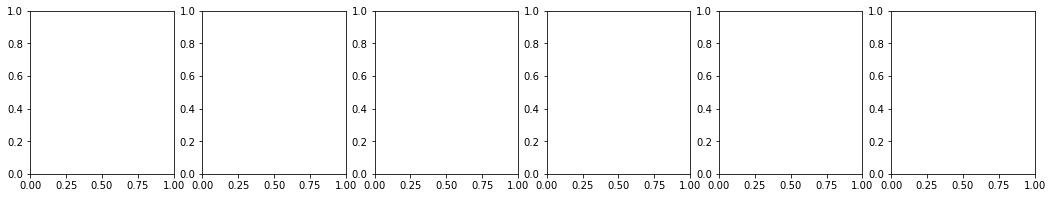

In [7]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, len(animeData.X.columns), figsize = (18, 3))
counter = 0
for i in animeData.X.columns:
    ax[counter].hist(animeData.X[i], bins = 100)
    ax[counter].set(ylabel = "Frequency")
    ax[counter].set(title = i)
    counter += 1
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[3].xaxis.set_major_formatter(formatter) 
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1)
ax.hist(animeData.y, bins = 100)
ax.set(xlabel = "score", ylabel = "Frequency")
plt.show()
import numpy as np
print("The mean value of our dataset's scores are {0}".format(np.round(np.mean(animeData.y),2)))

## Using our Prediction Model

#### Display our prediction results for "Blue Lock"

In [ ]:
BlueLockScoreTree = animeData.printScoreTree(49596)
BlueLockScoreLinear = animeData.printScoreLinearRegression(49596)

#### Test our Prediction Model for Many Animes
the function printScoreTree can take in a list of IDs as well as just a single ID

In [ ]:
listOfAnimes = [42962, 49979, 51212, 52046]
listOfAnimesScoreTree = animeData.printScoreTree(listOfAnimes)
listOfAnimesScoreLinear = animeData.printScoreLinearRegression(listOfAnimes)

## Analysing our Results

#### Error Scores
Let's see the error scores of each type of prediction model

In [ ]:
print(animeData.T_score, animeData.lr_score)

It appears that the Decision Tree Regressor provided a much higher score, meaning it should be better. Let's see if that is true in a sample of a few animes.

In [ ]:
#set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(18, 8))
 
# getting the true score
listOfAnimesScore = []
listOfAnimesName = []
for i in listOfAnimes:
    listOfAnimesScore.append(animeData.animes.loc[animeData.animes[animeData.animes["ID"]==i].index].iloc[0][10])
    listOfAnimesName.append(animes.loc[animes[animes["ID"]==i].index].iloc[0][1])

# Set position of bar on X axis
bar1 = np.arange(len(listOfAnimes))
bar2 = [x + barWidth for x in bar1]
bar3 = [x + barWidth for x in bar2]
 
# Make the plot
plt.bar(bar1, listOfAnimesScoreTree, color ='r', width = barWidth,
        edgecolor ='grey', label ='Tree Regressor')
plt.bar(bar2, listOfAnimesScoreLinear, color ='g', width = barWidth,
        edgecolor ='grey', label ='Linear Regression')
plt.bar(bar3, listOfAnimesScore, color ='b', width = barWidth,
        edgecolor ='grey', label ='True Value')
 
#Adding Xticks
plt.xticks([r + barWidth for r in range(len(listOfAnimes))], listOfAnimesName)
 
plt.legend()
plt.show()

In [ ]:
models = ["Decision Tree Regressor", "Linear Regression"]
for i in range(len(listOfAnimes)):
    #uncomment to see the exact error of the anime's graphed above
    #print("Error for {0} via Decision Tree Regressor is {1}".format(listOfAnimesName[i]), abs(listOfAnimesScore[i] - listOfAnimesScoreTree[i]))
    #print("Error for {0} via Linear Regression is {1}".format(listOfAnimesName[i]), abs(listOfAnimesScore[i] - listOfAnimesScoreLinear[i]))
    print("For {0}, the \033[1;3m\033[1;31m{1}\033[0m\033[0m provided a better result.".format(listOfAnimesName[i],
        models[(abs(listOfAnimesScore[i] - listOfAnimesScoreTree[i])) - (abs(listOfAnimesScore[i] - listOfAnimesScoreLinear[i])) >= 0]))

It appears there isn't a significant difference between each of the models. This is surprising considering our error scores. Perhaps updating our models so that there are more features, changing the weight of each feature may help produce accurate results. Nevertheless, it appears that our model isn't that far off from our true solution.

## Exception Handling in ScorePredictor
#### Example #1

When using the predictive models, the user must input an ID not representative of an anime used to fit the model.
```python
    def predictScoreTree(self, animeID):
        ...
        if animeID in self.animes["ID"]:
            raise ValueError("animeID is not the ID to any anime in self.animes")
    def predictScoreTree(self, animeID):
        ...
        if animeID in self.animes["ID"]:
            raise ValueError("animeID is not the ID to any anime in self.animes")
```
#### Example #2


When using the predictive models, the user must input an int representing an ID in the dataset.
```python
    def printScoreTree(self, animeID):
        ...
        if isinstance(i, int) == False:
            raise ValueError("animeID must be an int or list of ints")
    def printScoreLinearRegression(self, animeID):
        ...
        if isinstance(i, int) == False:
            raise ValueError("animeID must be an int or list of ints")
```

In [ ]:
FMABScoreTree = animeData.printScoreTree(5114)
FMABScoreLinear = animeData.printScoreLinearRegression(5114)